# Курсовой проект "Python для Data Science"

Задание: Используя данные из train.csv, построить модель для предсказания цен на недвижимость (квартиры). С помощью полученной модели предсказать цены для квартир из файла test.csv.

Целевая переменная: Price

Основная метрика: R2 - коэффициент детерминации (sklearn.metrics.r2_score)

### описание датасета:
* Id - номер квартиры в сете, можно объединять по нему данные разных таблиц
* DistrictId - категориальный признак. принадлежность разным районам
* Rooms - количество комнат. есть 0/NaN комнаты - это ошибка данных или студия/нежилое помещение
* Square, LifeSquare, KitchenSquare - общая, жилая и площадь кухни
* Floor - этаж квартиры
* HouseFloor - сколько этажей в доме
* HouseYear - когда построен дом
* Ecology_1 - состояние экологии. будет задача попробовать использовать поле. сделать выводы о нём.
* Ecology_2, Ecology_3 - какие-то коэффициенты. можно переводить в численный вид и строить с ними модель.
* Social_1, Social_2, Social_3 - социальная обстановка
* Healthcare_1, Healthcare_2 - показатели. которые связаны со здоровьем
* Shops_1, Shops_2 - наличие магазинов
* Price - цена квартиры. **target** переменная для модели.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.metrics import r2_score as r2
import warnings

warnings.filterwarnings('ignore')
pd.options.display.max_columns = 100

%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

In [2]:
data_train = pd.read_csv('input/train.csv')
data_test = pd.read_csv('input/test.csv')

data_train.shape, data_test.shape

((10000, 20), (5000, 19))

In [3]:
data_train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [4]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
Id               10000 non-null int64
DistrictId       10000 non-null int64
Rooms            10000 non-null float64
Square           10000 non-null float64
LifeSquare       7887 non-null float64
KitchenSquare    10000 non-null float64
Floor            10000 non-null int64
HouseFloor       10000 non-null float64
HouseYear        10000 non-null int64
Ecology_1        10000 non-null float64
Ecology_2        10000 non-null object
Ecology_3        10000 non-null object
Social_1         10000 non-null int64
Social_2         10000 non-null int64
Social_3         10000 non-null int64
Healthcare_1     5202 non-null float64
Helthcare_2      10000 non-null int64
Shops_1          10000 non-null int64
Shops_2          10000 non-null object
Price            10000 non-null float64
dtypes: float64(8), int64(9), object(3)
memory usage: 1.5+ MB


In [5]:
# изменим тип данных для Rooms и для HouseFloor
data_train['Rooms'] = data_train['Rooms'].astype('int64')
data_train['HouseFloor'] = data_train['HouseFloor'].astype('int64')

data_test['Rooms'] = data_test['Rooms'].astype('int64')
data_test['HouseFloor'] = data_test['HouseFloor'].astype('int64')

In [6]:
data_train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Id,10000.0,8383.407700,4859.019020,0.000000,4169.500000,8394.500000,12592.500000,1.679800e+04
DistrictId,10000.0,50.400800,43.587592,0.000000,20.000000,36.000000,75.000000,2.090000e+02
Rooms,10000.0,1.890500,0.839512,0.000000,1.000000,2.000000,2.000000,1.900000e+01
Square,10000.0,56.315775,21.058732,1.136859,41.774881,52.513310,65.900625,6.410652e+02
LifeSquare,7887.0,37.199645,86.241209,0.370619,22.769832,32.781260,45.128803,7.480592e+03
KitchenSquare,10000.0,6.273300,28.560917,0.000000,1.000000,6.000000,9.000000,2.014000e+03
Floor,10000.0,8.526700,5.241148,1.000000,4.000000,7.000000,12.000000,4.200000e+01
HouseFloor,10000.0,12.609400,6.775974,0.000000,9.000000,13.000000,17.000000,1.170000e+02
HouseYear,10000.0,3990.166300,200500.261427,1910.000000,1974.000000,1977.000000,2001.000000,2.005201e+07
Ecology_1,10000.0,0.118858,0.119025,0.000000,0.017647,0.075424,0.195781,5.218671e-01


In [7]:
# посмотрим на количество комнат
data_train['Rooms'].value_counts()

2     3880
1     3705
3     2235
4      150
5       18
0        8
10       2
6        1
19       1
Name: Rooms, dtype: int64

In [8]:
data_test['Rooms'].value_counts()

2     2030
1     1769
3     1099
4       90
5        7
6        2
0        2
17       1
Name: Rooms, dtype: int64

In [9]:
# разделим train данные на два сета
train, valid = train_test_split(data_train, test_size=0.3, random_state=42)

In [10]:
mean_year = np.round(train.loc[train['HouseYear'] <= 2020, 'HouseYear'].mean())
mean_year

1985.0

## Подготовка данных

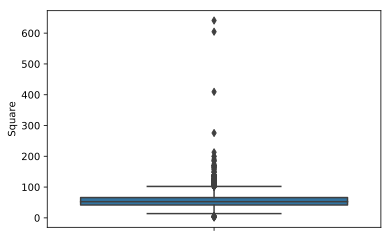

In [11]:
sns.boxplot(data_train['Square'], orient='v')

In [12]:
def clean_square(df):
    df.loc[df['Square'] > 250, 'Square'] = train['Square'].median()
    df.loc[(df['KitchenSquare'] < 3) | (df['KitchenSquare'] > 22), 'KitchenSquare'] = train['KitchenSquare'].median()

In [13]:
def clean_year(df, mean_year):
    df.loc[df['HouseYear'] > 2020, 'HouseYear'] = mean_year
    df.loc[df['HouseYear'] == 20052011, 'HouseYear'] = int((2005 + 2011) / 2)
    df.loc[df['HouseYear'] == 4968, 'HouseYear'] = 1968

In [14]:
def clean_life_square(df):
    df.loc[(df['LifeSquare'] < 5) | (df['LifeSquare'].isnull()), 'LifeSquare'] = df['Square']*0.85
    df.loc[df['Square'] < df['LifeSquare'], 'LifeSquare'] = df.loc[df['Square'] < df['LifeSquare'], 'Square']

In [15]:
def clean_rooms(df):
    df.loc[df['Rooms'] > 6, 'Rooms'] = train['Rooms'].median()
    df.loc[df['Rooms'] == 0, 'Rooms'] = train['Rooms'].median()

In [16]:
def clean_feature(df):
    df['Ecology_2'] = (df['Ecology_2'] == 'B').astype(int)
    df['Ecology_3'] = (df['Ecology_3'] == 'B').astype(int)
    df['Shops_2'] = (df['Shops_2'] == 'B').astype(int)

In [17]:
def prepare_data(df, mean_year=mean_year):
    clean_square(df)
    clean_life_square(df)
    clean_year(df, mean_year)
    clean_rooms(df)
    clean_feature(df)

In [18]:
prepare_data(train)
prepare_data(valid)
train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9069,14604,23,1.0,41.681380,22.796166,8.0,14,17,2015.0,0.075779,1,1,6,1437,3,NaN,0,2,1,88504.384965
2603,5621,23,3.0,163.495333,161.504222,12.0,5,3,1977.0,0.014073,1,1,2,475,0,NaN,0,0,1,207007.956663
7738,235,87,1.0,39.710131,19.538663,8.0,4,17,1986.0,0.100456,1,1,43,7227,0,NaN,1,6,0,182126.280899
1579,16258,48,3.0,96.056784,96.056784,6.0,15,1,2017.0,0.041125,1,1,46,9515,5,NaN,1,10,1,524365.550705
5058,10773,77,3.0,79.195825,44.421062,10.0,16,17,1984.0,0.298205,1,1,16,4048,3,NaN,1,3,1,322048.433990


## model

In [19]:
feats = ['DistrictId', 'Rooms', 'Square', 'KitchenSquare', 'HouseFloor', 'HouseYear', 'Ecology_1',
         'Ecology_3', 'Helthcare_2', 'Social_3', 'Shops_1', 'Shops_2']

In [20]:
def evaluate_model(model, train, valid, metric, feats, target, max_depth):
    dtr = model(max_depth=max_depth, random_state=42, criterion='mse')
    dtr.fit(train.loc[:, feats], train[target])
    y_pred_train = dtr.predict(train.loc[:, feats])
    y_pred_valid = dtr.predict(valid.loc[:, feats])
    metric_train = metric(train['Price'], y_pred_train)
    metric_valid = metric(valid['Price'], y_pred_valid)
    return metric_train, metric_valid

In [21]:
def check_param(min_value, max_value, model, train=train, valid=valid, metric=r2, feats=feats, target='Price'):
    max_depth_arr = []
    metric_train_arr = []
    metric_valid_arr = []

    for i in range(min_value, max_value+1):
        res = evaluate_model(model, train, valid, metric, feats, target, max_depth=i)
        metric_train_arr.append(res[0])
        metric_valid_arr.append(res[1])
        max_depth_arr.append(i)
    return max_depth_arr, metric_train_arr, metric_valid_arr

In [22]:
max_depth_arr, metric_train_arr, metric_valid_arr = check_param(10, 20, model=RFR)

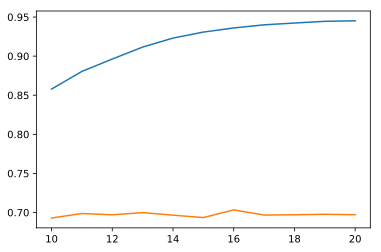

In [23]:
plt.plot(max_depth_arr, metric_train_arr)
plt.plot(max_depth_arr, metric_valid_arr)

In [24]:
model = RFR(n_estimators=170, max_depth=16, random_state=42, criterion='mse')

In [25]:
model.fit(train.loc[:, feats], train['Price'])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=16,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=170, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [26]:
y_pred_train = model.predict(train.loc[:, feats])

In [27]:
r2(train['Price'], y_pred_train)

0.9516419727273399

In [28]:
y_pred_valid = model.predict(valid.loc[:, feats])

In [29]:
r2(valid['Price'], y_pred_valid)

0.7240485054120376

In [30]:
prepare_data(data_test)
data_test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882643,33.432782,6.0,6,14,1972.0,0.310199,1,1,11,2748,1,NaN,0,0,1
1,15856,74,2.0,69.263183,58.873706,6.0,6,1,1977.0,0.075779,1,1,6,1437,3,NaN,0,2,1
2,5480,190,1.0,13.597819,13.597819,12.0,2,5,1909.0,0.000000,1,1,30,7538,87,4702.0,5,5,1
3,15664,47,2.0,73.046609,51.940842,9.0,22,22,2007.0,0.101872,1,1,23,4583,3,NaN,3,3,1
4,14275,27,1.0,47.527111,43.387569,6.0,17,17,2017.0,0.072158,1,1,2,629,1,NaN,0,0,0


In [31]:
data_test['Price'] = model.predict(data_test.loc[:, feats])

In [32]:
data_test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,725,58,2.0,49.882643,33.432782,6.0,6,14,1972.0,0.310199,1,1,11,2748,1,NaN,0,0,1,148712.869062
1,15856,74,2.0,69.263183,58.873706,6.0,6,1,1977.0,0.075779,1,1,6,1437,3,NaN,0,2,1,222467.962023
2,5480,190,1.0,13.597819,13.597819,12.0,2,5,1909.0,0.000000,1,1,30,7538,87,4702.0,5,5,1,197271.392711
3,15664,47,2.0,73.046609,51.940842,9.0,22,22,2007.0,0.101872,1,1,23,4583,3,NaN,3,3,1,321349.260785
4,14275,27,1.0,47.527111,43.387569,6.0,17,17,2017.0,0.072158,1,1,2,629,1,NaN,0,0,0,141011.084687


In [33]:
data_test.loc[:, ['Id', 'Price']].to_csv('AKurov_predictions.csv', index=False)